Loading data from block slider simulation...
Data loaded successfully.
Dataset shape: (5001, 4)
Time range: 0.0 to 5000.0 years
Number of data points: 5001

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m
Normal Stress: 5.00e+07 Pa


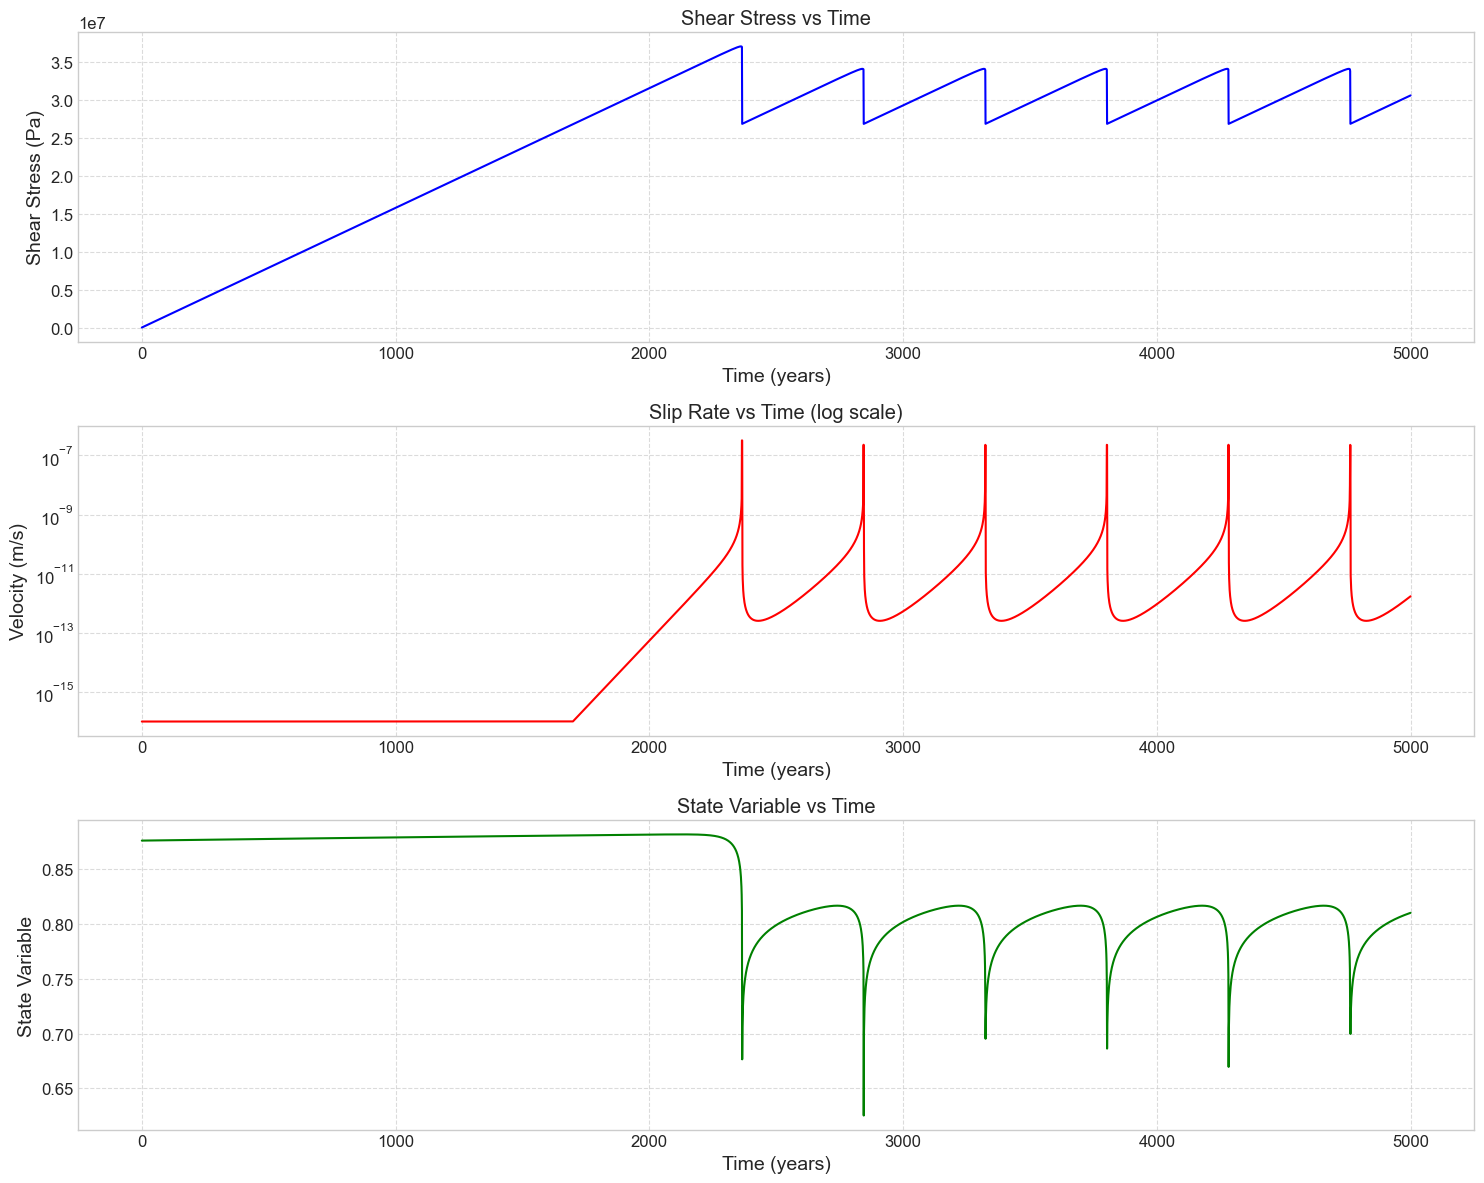


--- Minimal Preprocessing for Equation Discovery ---
Filtering data to use only the stationary regime (after 2000 years)...
Computing derivatives directly with numpy...

--- Direct Analysis of Equations ---
Theoretical equations for comparison:
x: dx/dt = v
state: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)
tau: dtau/dt = 5.000000e-04 - 5.000000e+05*v

--- Analysis of dx/dt equation ---


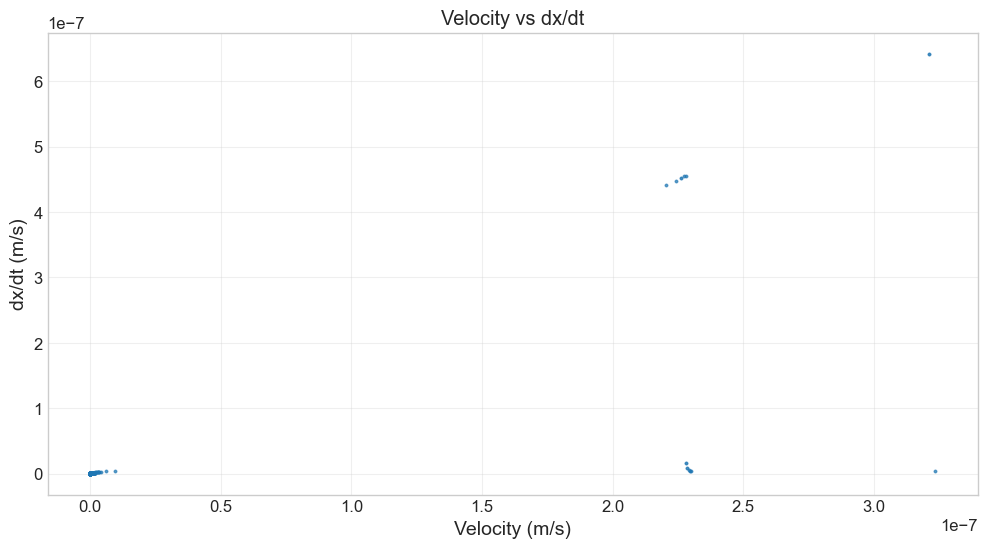

dx/dt = -1.3065e-11 + 1.0016e+00 * v
R² score: 0.5074
Theoretical coefficient: 1.0
Fitted coefficient: 1.0016
Relative error: 0.16%

--- Analysis of dstate/dt equation ---


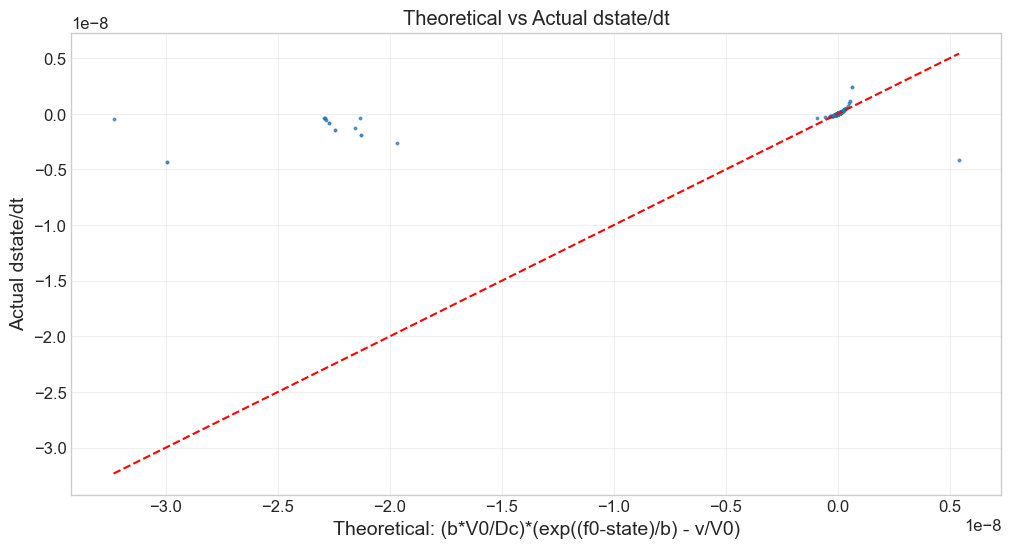

dstate/dt = -1.0936e-08 * exp((f0-state)/b) - -5.5318e-09 * v/V0
R² score: 0.6162
Theoretical coefficient: 1.0000e-07
Fitted coefficient 1: -1.0936e-08
Fitted coefficient 2: -5.5318e-09
Relative error 1: 110.94%
Relative error 2: 105.53%

--- Analysis of dtau/dt equation ---


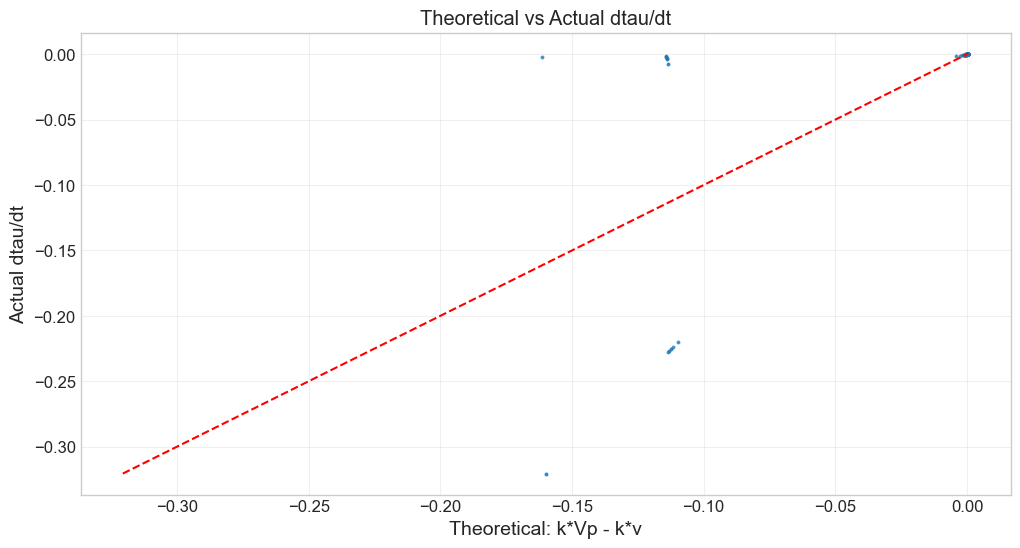

dtau/dt = 5.0653e-04 - 5.0082e+05 * v
R² score: 0.5074
Theoretical loading rate (k*Vp): 5.0000e-04
Theoretical spring constant (k): 5.0000e+05
Fitted loading rate: 5.0653e-04
Fitted spring constant: 5.0082e+05
Relative error loading: 1.31%
Relative error spring: 0.16%

--- Summary of Equation Discovery ---
Variable | Theoretical Equation | Discovered Equation | R² Score
--------------------------------------------------------------------------------
dx/dt    | dx/dt = v                   | dx/dt = -1.31e-11 + 1.00e+00 * v           | 0.5074
dstate/dt| dstate/dt = 1.00e-07 * (exp((f0-state)/b) - v/V0) | dstate/dt = -1.09e-08 * exp((f0-state)/b) - -5.53e-09 * v/V0 | 0.6162
dtau/dt  | dtau/dt = 5.00e-04 - 5.00e+05 * v | dtau/dt = 5.07e-04 - 5.01e+05 * v | 0.5074

--- Reconstructed System of Equations ---
System of equations for simulation:
dx/dt = 1.0016e+00 * v + -1.3065e-11
dstate/dt = -1.0936e-08 * exp((f0-state)/b) - -5.5318e-09 * v/V0
dtau/dt = 5.0653e-04 - 5.0082e+05 * v
dv/dt is ha

In [1]:
# ----------------------------------------------------------------------------------
# Direct Approach for Rate-State Friction Equations
# ----------------------------------------------------------------------------------

# Import necessary packages
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import pysindy as ps

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading data from block slider simulation...")
# Load the data
try:
    # Use relative path assuming notebooks are in the "notebooks" directory
    X_raw = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Trying alternative paths...")
    # Alternative loading paths
    try:
        X_raw = np.load('data/block_slider_data.npy')
        t = np.load('data/block_slider_time.npy')
        print("Data loaded from alternative path.")
    except FileNotFoundError:
        print("Could not find data files. Please run the simulation notebook first.")
        # Create dummy data for testing
        print("Creating dummy data for testing...")
        t = np.linspace(0, 100, 1001)
        X_raw = np.zeros((1001, 4))
        X_raw[:, 0] = np.linspace(0, 1, 1001)  # Position
        X_raw[:, 1] = 0.001 * np.ones(1001)    # Velocity
        X_raw[:, 2] = 0.5 * np.ones(1001)      # State
        X_raw[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Extract individual variables and convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

# Reorganize the data as before
x_data = X_raw[:, 0]       # Position
v_data = X_raw[:, 1]       # Velocity (slip rate)
state_data = X_raw[:, 2]   # State variable
tau_data = X_raw[:, 3]     # Shear stress

# Stack all columns for analysis
X = np.column_stack((x_data, v_data, state_data, tau_data))
feature_names = ["x", "v", "state", "tau"]

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")
print(f"Number of data points: {len(t)}")

# Define physical parameters from the simulation for reference
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
sigma_n = 50e6             # Normal stress (Pa)
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")
print(f"Normal Stress: {sigma_n:.2e} Pa")

# Plot the raw data
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.title('Shear Stress vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(312)
plt.semilogy(t_years, v_data, 'r-', linewidth=1.5)
plt.title('Slip Rate vs Time (log scale)')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(313)
plt.plot(t_years, state_data, 'g-', linewidth=1.5)
plt.title('State Variable vs Time')
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/raw_data.png', dpi=300)
plt.show()

# ----------------------------------------------------------------------------------
# MINIMAL PREPROCESSING: Focus on preserving physics
# ----------------------------------------------------------------------------------
print("\n--- Minimal Preprocessing for Equation Discovery ---")

# Filter data to use only after 2000 years (stationary regime)
print("Filtering data to use only the stationary regime (after 2000 years)...")
regime_idx = t_years >= 2000
X_regime = X[regime_idx, :]
t_regime = t[regime_idx]
t_years_regime = t_years[regime_idx]

# Special handling for velocity - use raw velocity without log transform
# No standardization to preserve the physics
X_processed = X_regime.copy()

# Compute derivatives directly using numpy
print("Computing derivatives directly with numpy...")
dt = np.diff(t_regime)
X_dot = np.zeros_like(X_processed)

# For all variables except the first point
X_dot[1:] = np.diff(X_processed, axis=0) / dt[:, None]
# For the first point, use forward difference
X_dot[0] = (X_processed[1] - X_processed[0]) / dt[0]

# ----------------------------------------------------------------------------------
# DIRECT ANALYSIS: Examine each equation separately
# ----------------------------------------------------------------------------------
print("\n--- Direct Analysis of Equations ---")

# Define theoretical equations for reference
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b * V0 / Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k * Vp:.6e} - {k:.6e}*v"
}

print("Theoretical equations for comparison:")
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Use a subset of the data for faster analysis
sample_size = 10000
sample_idx = np.linspace(0, len(X_processed)-1, sample_size, dtype=int)
X_sample = X_processed[sample_idx]
X_dot_sample = X_dot[sample_idx]

# -----------------------------------------------------------------
# EQUATION 1: dx/dt = v
# -----------------------------------------------------------------
print("\n--- Analysis of dx/dt equation ---")

# Plot v vs dx/dt
plt.figure(figsize=(12, 6))
plt.scatter(X_sample[:, 1], X_dot_sample[:, 0], s=3, alpha=0.3)
plt.title('Velocity vs dx/dt')
plt.xlabel('Velocity (m/s)')
plt.ylabel('dx/dt (m/s)')
plt.grid(True, alpha=0.3)
plt.savefig('../figures/v_vs_dxdt.png', dpi=300)
plt.show()

# Compute linear regression for dx/dt = v
lr_x = LinearRegression(fit_intercept=True)
lr_x.fit(X_sample[:, 1].reshape(-1, 1), X_dot_sample[:, 0])
print(f"dx/dt = {lr_x.intercept_:.4e} + {lr_x.coef_[0]:.4e} * v")
print(f"R² score: {lr_x.score(X_sample[:, 1].reshape(-1, 1), X_dot_sample[:, 0]):.4f}")

# Theoretical vs fitted
print(f"Theoretical coefficient: 1.0")
print(f"Fitted coefficient: {lr_x.coef_[0]:.4f}")
print(f"Relative error: {abs(lr_x.coef_[0] - 1.0)/1.0*100:.2f}%")

# -----------------------------------------------------------------
# EQUATION 2: dstate/dt = (b*V0/Dc)*(exp((f0-state)/b) - v/V0)
# -----------------------------------------------------------------
print("\n--- Analysis of dstate/dt equation ---")

# Compute expected terms
exp_term = np.exp((f0 - X_sample[:, 2]) / b)
v_term = X_sample[:, 1] / V0
theoretical_dstate = (b * V0 / Dc) * (exp_term - v_term)

# Plot theoretical vs actual dstate/dt
plt.figure(figsize=(12, 6))
plt.scatter(theoretical_dstate, X_dot_sample[:, 2], s=3, alpha=0.3)
plt.title('Theoretical vs Actual dstate/dt')
plt.xlabel('Theoretical: (b*V0/Dc)*(exp((f0-state)/b) - v/V0)')
plt.ylabel('Actual dstate/dt')
plt.grid(True, alpha=0.3)
# Add diagonal line for reference
min_val = min(np.min(theoretical_dstate), np.min(X_dot_sample[:, 2]))
max_val = max(np.max(theoretical_dstate), np.max(X_dot_sample[:, 2]))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.savefig('../figures/theoretical_vs_actual_dstate.png', dpi=300)
plt.show()

# Create design matrix for dstate/dt
X_state = np.column_stack((exp_term, -v_term))
lr_state = LinearRegression(fit_intercept=False)
lr_state.fit(X_state, X_dot_sample[:, 2])

# Report coefficients
print(f"dstate/dt = {lr_state.coef_[0]:.4e} * exp((f0-state)/b) - {-lr_state.coef_[1]:.4e} * v/V0")
print(f"R² score: {lr_state.score(X_state, X_dot_sample[:, 2]):.4f}")

# Theoretical vs fitted
theo_coef = b * V0 / Dc
print(f"Theoretical coefficient: {theo_coef:.4e}")
print(f"Fitted coefficient 1: {lr_state.coef_[0]:.4e}")
print(f"Fitted coefficient 2: {-lr_state.coef_[1]:.4e}")
print(f"Relative error 1: {abs(lr_state.coef_[0] - theo_coef)/theo_coef*100:.2f}%")
print(f"Relative error 2: {abs(-lr_state.coef_[1] - theo_coef)/theo_coef*100:.2f}%")

# -----------------------------------------------------------------
# EQUATION 3: dtau/dt = k*Vp - k*v
# -----------------------------------------------------------------
print("\n--- Analysis of dtau/dt equation ---")

# Compute expected terms
loading_term = k * Vp * np.ones_like(X_sample[:, 1])
unloading_term = -k * X_sample[:, 1]
theoretical_dtau = loading_term + unloading_term

# Plot theoretical vs actual dtau/dt
plt.figure(figsize=(12, 6))
plt.scatter(theoretical_dtau, X_dot_sample[:, 3], s=3, alpha=0.3)
plt.title('Theoretical vs Actual dtau/dt')
plt.xlabel('Theoretical: k*Vp - k*v')
plt.ylabel('Actual dtau/dt')
plt.grid(True, alpha=0.3)
# Add diagonal line for reference
min_val = min(np.min(theoretical_dtau), np.min(X_dot_sample[:, 3]))
max_val = max(np.max(theoretical_dtau), np.max(X_dot_sample[:, 3]))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.savefig('../figures/theoretical_vs_actual_dtau.png', dpi=300)
plt.show()

# Create design matrix for dtau/dt
X_tau = np.column_stack((np.ones_like(X_sample[:, 1]), X_sample[:, 1]))
lr_tau = LinearRegression(fit_intercept=False)
lr_tau.fit(X_tau, X_dot_sample[:, 3])

# Report coefficients
print(f"dtau/dt = {lr_tau.coef_[0]:.4e} - {-lr_tau.coef_[1]:.4e} * v")
print(f"R² score: {lr_tau.score(X_tau, X_dot_sample[:, 3]):.4f}")

# Theoretical vs fitted
print(f"Theoretical loading rate (k*Vp): {k*Vp:.4e}")
print(f"Theoretical spring constant (k): {k:.4e}")
print(f"Fitted loading rate: {lr_tau.coef_[0]:.4e}")
print(f"Fitted spring constant: {-lr_tau.coef_[1]:.4e}")
print(f"Relative error loading: {abs(lr_tau.coef_[0] - k*Vp)/(k*Vp)*100:.2f}%")
print(f"Relative error spring: {abs(-lr_tau.coef_[1] - k)/k*100:.2f}%")

# -----------------------------------------------------------------
# SUMMARY TABLE: Comparison of theoretical and discovered equations
# -----------------------------------------------------------------
print("\n--- Summary of Equation Discovery ---")
print("Variable | Theoretical Equation | Discovered Equation | R² Score")
print("-" * 80)
print(f"dx/dt    | dx/dt = v                   | dx/dt = {lr_x.intercept_:.2e} + {lr_x.coef_[0]:.2e} * v           | {lr_x.score(X_sample[:, 1].reshape(-1, 1), X_dot_sample[:, 0]):.4f}")
print(f"dstate/dt| dstate/dt = {theo_coef:.2e} * (exp((f0-state)/b) - v/V0) | dstate/dt = {lr_state.coef_[0]:.2e} * exp((f0-state)/b) - {-lr_state.coef_[1]:.2e} * v/V0 | {lr_state.score(X_state, X_dot_sample[:, 2]):.4f}")
print(f"dtau/dt  | dtau/dt = {k*Vp:.2e} - {k:.2e} * v | dtau/dt = {lr_tau.coef_[0]:.2e} - {-lr_tau.coef_[1]:.2e} * v | {lr_tau.score(X_tau, X_dot_sample[:, 3]):.4f}")

# -----------------------------------------------------------------
# RECONSTRUCTED SYSTEM: Create equations for simulation
# -----------------------------------------------------------------
print("\n--- Reconstructed System of Equations ---")

# Define the rate-state friction equations using the discovered coefficients
def rate_state_eqs(t, y, a=a, b=b, V0=V0, f0=f0, k=k, Vp=Vp, sigma_n=sigma_n, Dc=Dc):
    """Rate-state friction equations using discovered coefficients"""
    x, v, state, tau = y
    
    # Use coefficients from linear regression
    dx_dt = lr_x.coef_[0] * v + lr_x.intercept_
    dstate_dt = lr_state.coef_[0] * np.exp((f0 - state) / b) - (-lr_state.coef_[1]) * (v / V0)
    dtau_dt = lr_tau.coef_[0] - (-lr_tau.coef_[1]) * v
    
    return [dx_dt, 0, dstate_dt, dtau_dt]  # v dot not needed for simulating

print("System of equations for simulation:")
print(f"dx/dt = {lr_x.coef_[0]:.4e} * v + {lr_x.intercept_:.4e}")
print(f"dstate/dt = {lr_state.coef_[0]:.4e} * exp((f0-state)/b) - {-lr_state.coef_[1]:.4e} * v/V0")
print(f"dtau/dt = {lr_tau.coef_[0]:.4e} - {-lr_tau.coef_[1]:.4e} * v")
print("dv/dt is handled implicitly through the friction law")

print("\nAnalysis complete!")